In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2
%load_ext lab_black

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"

In [2]:
dataset_name = "V1_Mouse_Brain_Sagittal_Anterior"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainSerial1SA_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


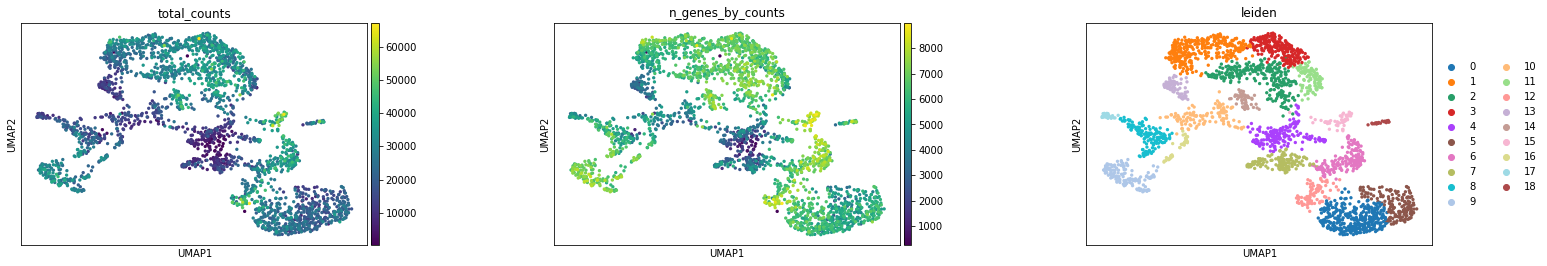

In [6]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

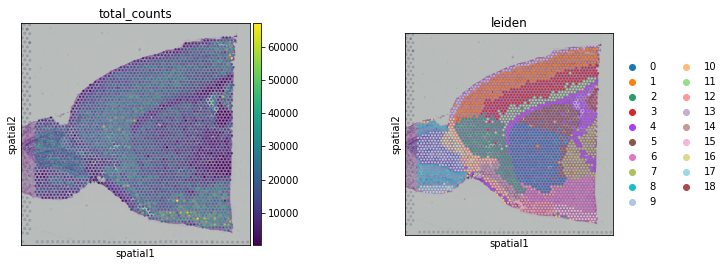

In [7]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "leiden"])

In [8]:
# !pip install astropy

From the docs:
- max radii should be this one `max(radii) < (area/2)**0.5.`
- different modes:
 - translation: computes intersection of rectangular are based on bounds
 - ohser: weighted edge effect
 - var-width: uses boundary distance of each observed point to account for edge-effects
 - ripley: weight of edge correction as function of proporitons of circumferences centered at each data point

In [9]:
from astropy.stats import RipleysKEstimator

In [11]:
adata.obsm["spatial"][:, 0].ptp()+100

8053

In [58]:
area =

In [34]:
(area / 2) ** 0.5

627.1176125735906

In [79]:
# z = np.array(adata[adata.obs.leiden == "0"].obsm["spatial"])

area = int(adata.obsm["spatial"][:, 0].ptp() ** 2)
area_min = int(adata.obsm["spatial"].min() - 100)
area_max = int(adata.obsm["spatial"].max() + 100)
max_radii = int(((area / 2) ** 0.5) / 2)
z = np.random.uniform(low=area_min, high=area_max, size=(3000, 2))

In [80]:
Kest = RipleysKEstimator(
    area=area,
    x_max=area_max,
    y_max=area_max,
    x_min=area_min,
    y_min=area_min,
)

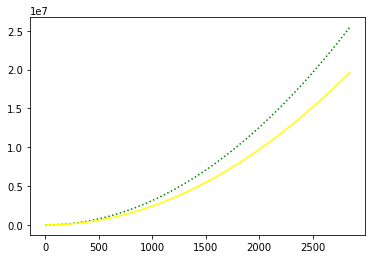

In [87]:
r = np.linspace(0, max_radii, 50)
plt.plot(r, Kest.poisson(r), color="green", ls=":", label=r"$K_{pois}$")
plt.plot(
    r,
    Kest(data=z, radii=r, mode="ripley"),
    color="yellow",
    label=r"$K_{ripley}$",
)

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


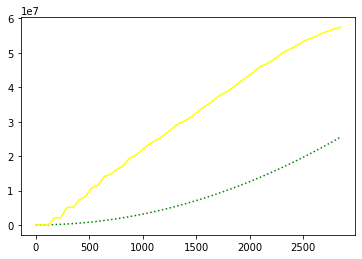

In [100]:
z = adata[adata.obs.leiden == "10"].obsm["spatial"]
r = np.linspace(0, max_radii, 50)
plt.plot(r, Kest.poisson(r), color="green", ls=":", label=r"$K_{pois}$")
plt.plot(
    r,
    Kest(data=z, radii=r, mode="ripley"),
    color="yellow",
    label=r"$K_{ripley}$",
)